В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [119]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import timeit
%matplotlib notebook

In [120]:
X = pd.read_csv('weather.csv')

In [121]:
y = X.RainTomorrow.replace({'No': 0, 'Yes': 1})

In [122]:
del X['RainTomorrow']

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [123]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [124]:
def probability(theta, X):
    return 1 / (1 + np.exp(-np.dot(X, theta)))
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [125]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    return (prob >= threshold).astype(int)

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [126]:
def logloss(theta, X, y): 
    eps = 1e-15  
    prob = probability(theta, X)
    prob = np.maximum(eps, np.minimum(1 - eps, prob))  
    result = -np.mean(y * np.log(prob) + (1 - y) * np.log(1 - prob))    
    return result

In [127]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [128]:
def gradient(theta, X, y):
    prob = probability(theta, X)
    result = np.dot(X.T, (prob - y)) / len(y)    
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [129]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [130]:
X, y = make_classification(n_samples=2000)

<IPython.core.display.Javascript object>


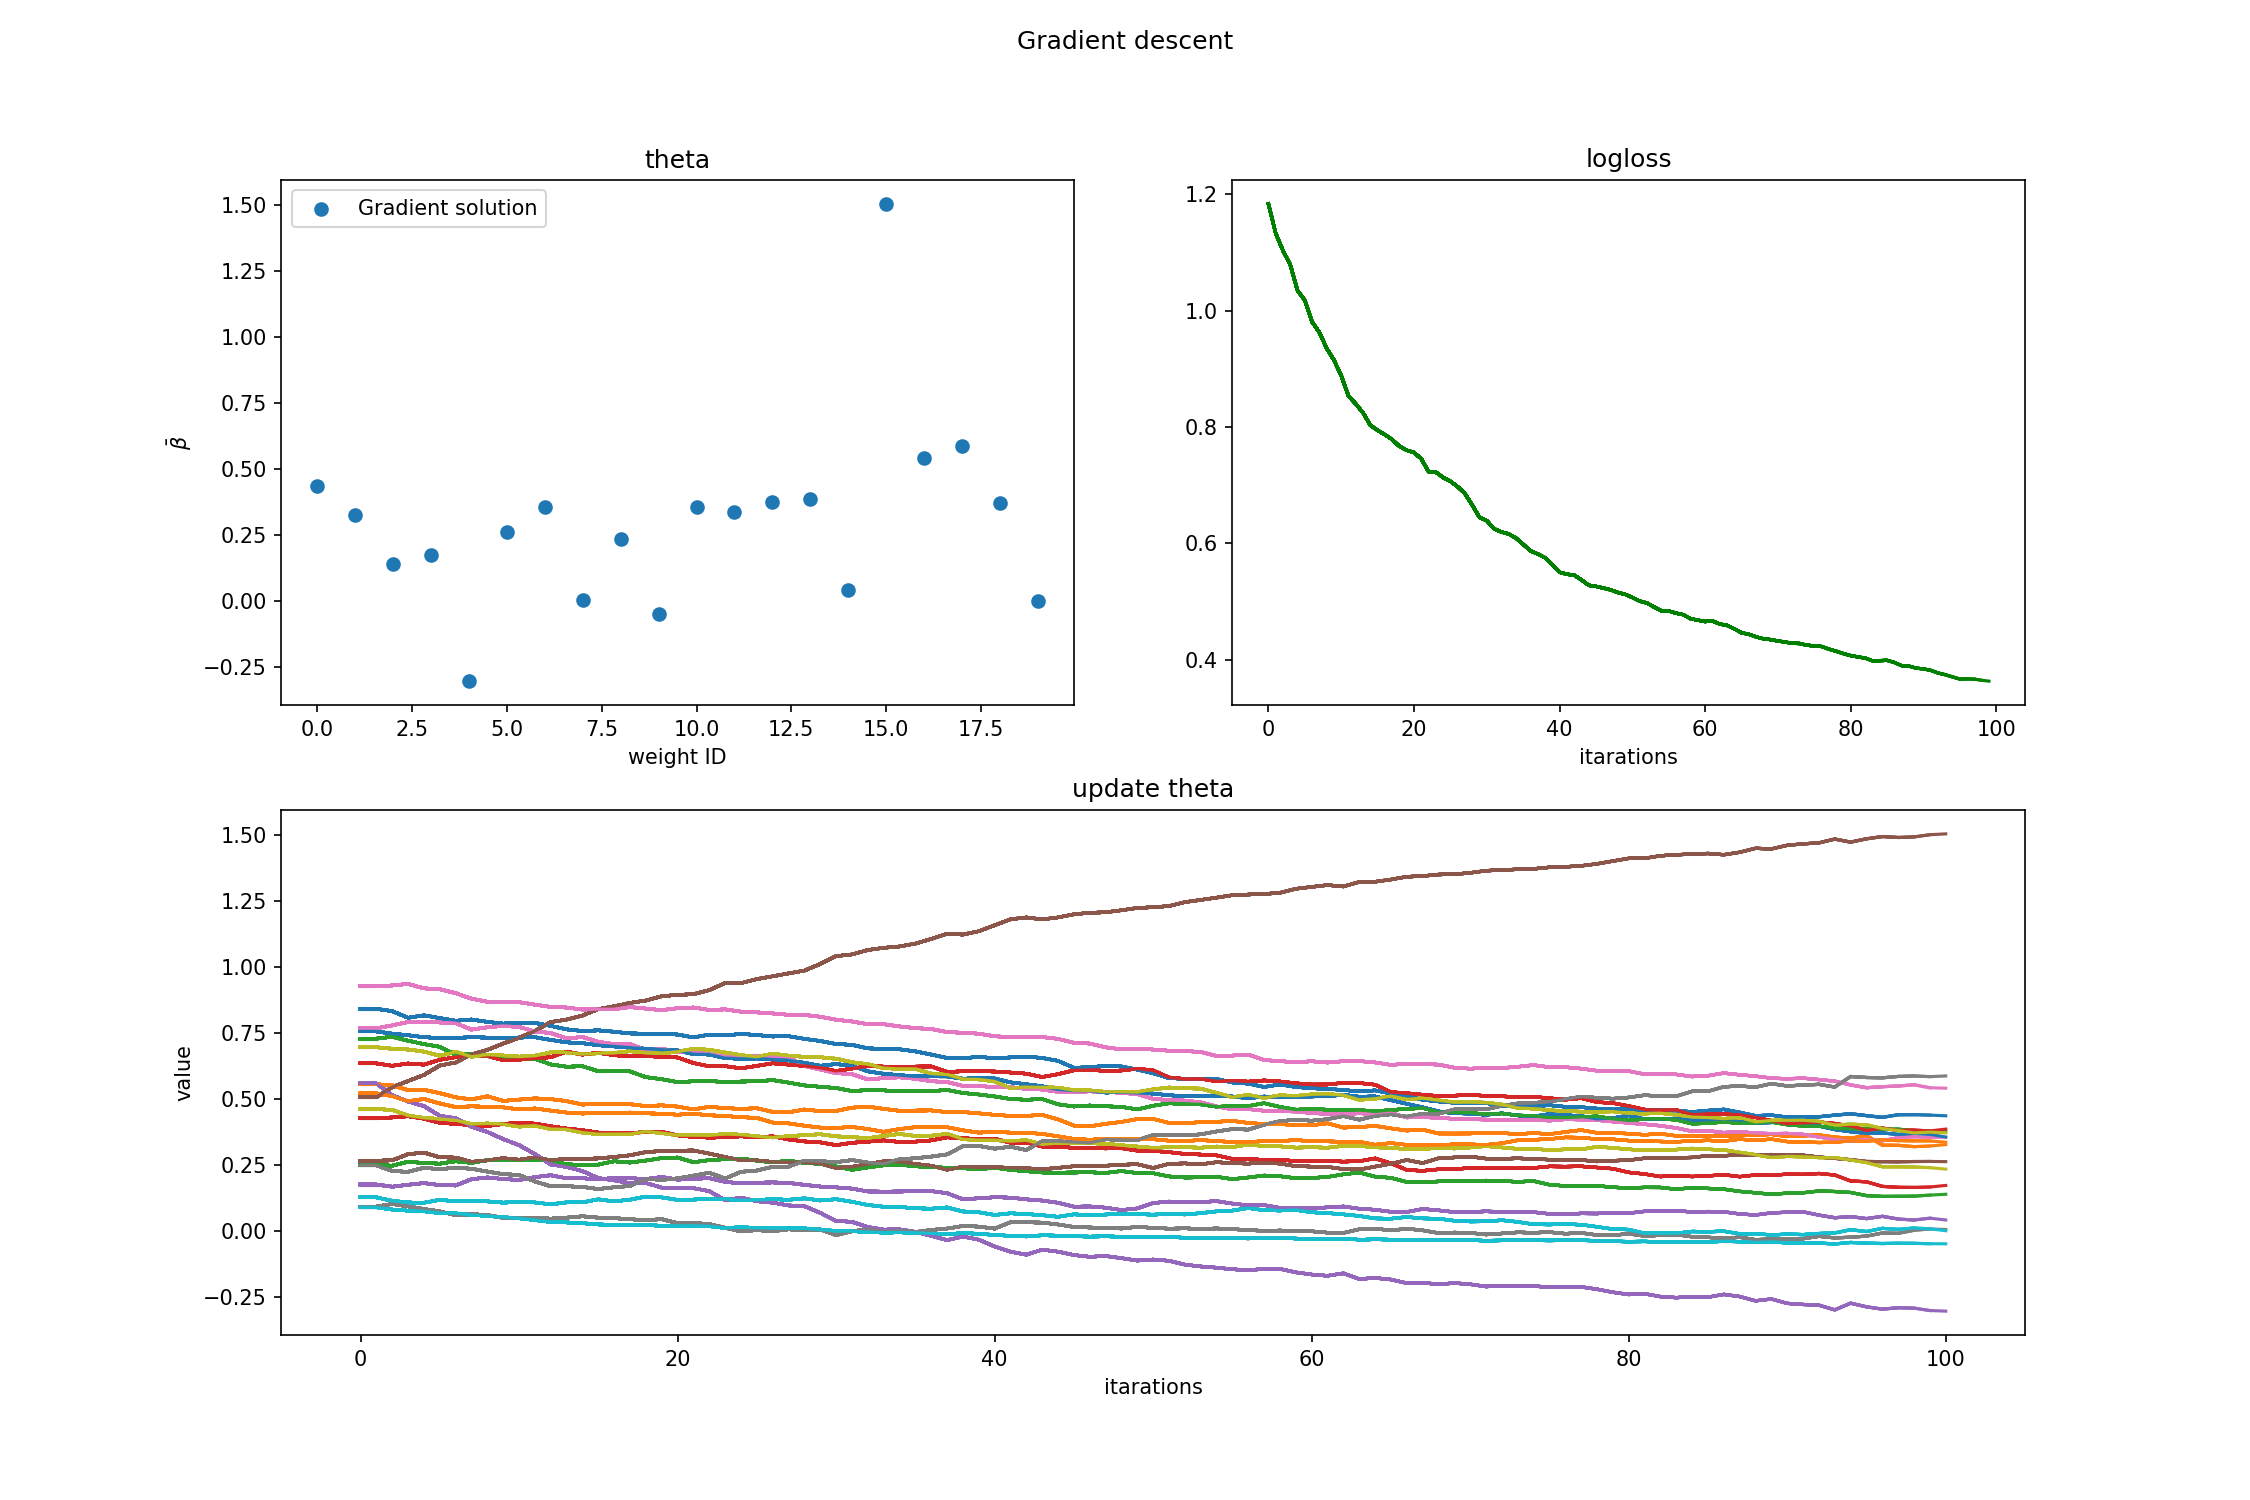

In [131]:
optimal_theta = fit(X, y)

In [132]:
y_pred = binary_class_prediction(optimal_theta, X)

## Работа с данными

In [133]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [134]:
df = pd.read_csv("weather.csv", index_col=0)
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


In [135]:
df.shape

(142193, 23)

In [136]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [137]:
df.drop("Date", axis=1, inplace=True)

In [138]:
def calculate_missing_values(df):
    total_rows = df.shape[0]
    for column in df.columns:
        missing_values = df[column].isnull().sum()
        if missing_values > 0:
            missing_percentage = (missing_values / total_rows) * 100
            print(f"Столбец '{column}' имеет {missing_percentage:.2f}% пропущенных значений, тип данных: '{df[column].dtype}'")

calculate_missing_values(df)

Столбец 'MinTemp' имеет 0.45% пропущенных значений, тип данных: 'float64'
Столбец 'MaxTemp' имеет 0.23% пропущенных значений, тип данных: 'float64'
Столбец 'Rainfall' имеет 0.99% пропущенных значений, тип данных: 'float64'
Столбец 'Evaporation' имеет 42.79% пропущенных значений, тип данных: 'float64'
Столбец 'Sunshine' имеет 47.69% пропущенных значений, тип данных: 'float64'
Столбец 'WindGustDir' имеет 6.56% пропущенных значений, тип данных: 'object'
Столбец 'WindGustSpeed' имеет 6.52% пропущенных значений, тип данных: 'float64'
Столбец 'WindDir9am' имеет 7.04% пропущенных значений, тип данных: 'object'
Столбец 'WindDir3pm' имеет 2.66% пропущенных значений, тип данных: 'object'
Столбец 'WindSpeed9am' имеет 0.95% пропущенных значений, тип данных: 'float64'
Столбец 'WindSpeed3pm' имеет 1.85% пропущенных значений, тип данных: 'float64'
Столбец 'Humidity9am' имеет 1.25% пропущенных значений, тип данных: 'float64'
Столбец 'Humidity3pm' имеет 2.54% пропущенных значений, тип данных: 'float64'

In [139]:
#df.dropna(subset=['RainToday'], inplace=True)

In [140]:
df.fillna(value={'MinTemp': df['MinTemp'].mean(), 
                 'MaxTemp': df['MaxTemp'].mean(),
                 'Rainfall': df['Rainfall'].mean(), 
                 'WindGustSpeed': df['WindGustSpeed'].mean(),
                 'WindSpeed9am': df['WindSpeed9am'].mean(), 
                 'WindSpeed3pm': df['WindSpeed3pm'].mean(),
                 'Humidity9am': df['Humidity9am'].mean(), 
                 'Humidity3pm': df['Humidity3pm'].mean(),
                 'Pressure9am': df['Pressure9am'].mean(), 
                 'Pressure3pm': df['Pressure3pm'].mean(),
                 'Temp9am': df['Temp9am'].mean(), 
                 'Temp3pm': df['Temp3pm'].mean(),
                 'WindGustDir': df['WindGustDir'].mode()[0],
                 'WindDir9am': df['WindDir9am'].mode()[0],
                 'WindDir3pm': df['WindDir3pm'].mode()[0]}, 
          inplace=True)

In [141]:
calculate_missing_values(df)

Столбец 'Evaporation' имеет 42.79% пропущенных значений, тип данных: 'float64'
Столбец 'Sunshine' имеет 47.69% пропущенных значений, тип данных: 'float64'
Столбец 'Cloud9am' имеет 37.74% пропущенных значений, тип данных: 'float64'
Столбец 'Cloud3pm' имеет 40.15% пропущенных значений, тип данных: 'float64'
Столбец 'RainToday' имеет 0.99% пропущенных значений, тип данных: 'object'


In [142]:
#columns_to_drop = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
#df.drop(columns=columns_to_drop, inplace=True)

df.fillna(value={'Evaporation': df['Evaporation'].mean(), 
                 'Sunshine': df['Sunshine'].mean(),
                 'Cloud9am': df['Cloud9am'].mean(), 
                 'Cloud3pm': df['Cloud3pm'].mean(),
                 'RainToday': df['RainToday'].mode()[0]},
         inplace=True)

In [143]:
y = df.RainTomorrow.replace({"No": 0, "Yes": 1})
X = df.drop('RainTomorrow', axis=1)

In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  OneHotEncoder
scaler = MinMaxScaler()

In [145]:
categorical_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Location']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')  
encoded_features = encoder.fit_transform(X[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_columns))
X.drop(columns=categorical_columns, inplace=True)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = pd.concat([X, encoded_df], axis=1)

In [146]:
X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera
0,0.516509,0.523629,0.001617,0.037723,0.525852,0.294574,0.153846,0.275862,0.71,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.375000,0.565217,0.000000,0.037723,0.525852,0.294574,0.030769,0.252874,0.44,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.504717,0.576560,0.000000,0.037723,0.525852,0.310078,0.146154,0.298851,0.38,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.417453,0.620038,0.000000,0.037723,0.525852,0.139535,0.084615,0.103448,0.45,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.613208,0.701323,0.002695,0.037723,0.525852,0.271318,0.053846,0.229885,0.82,0.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Тестирование моделей

In [147]:
split_index = int(0.75 * len(df))

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [148]:
def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

### Логистическая регрессия реализованная самостоятельно

In [149]:
X_train_val = X_train.iloc[:, :].values
y_train_val = y_train.iloc[:].values 
X_test_val = X_test.iloc[:, :].values
y_test_val = y_test.iloc[:].values 

In [150]:
start_time = time.time()
optimal_theta = fit(X_train_val, y_train_val, batch_size=500, h=0.2,  iters=2000, plot=False)
end_time = time.time()

y_my_reg_pred = binary_class_prediction(optimal_theta, X_test_val)

execution_time_my = round((end_time - start_time), 3)
print("Время выполнения кода:", execution_time_my, "секунд")

Время выполнения кода: 16.171 секунд


In [151]:
calculate_metrics(y_test_val, y_my_reg_pred)

Accuracy: 0.8376606936903992
F1 score: 0.5373947895791583
Precision: 0.43719838267901395
Recall: 0.697171381031614


### Логистическая регрессия 

In [152]:
'''
reg_model = LogisticRegression()

reg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga']
}


reg_grid_search = GridSearchCV(reg_model, reg_param_grid, cv=5, n_jobs=-1)

start_time = time.time()
reg_grid_search.fit(X_train, y_train)
end_time = time.time()

print("Лучшие параметры:", reg_grid_search.best_params_)
print("Лучшее значение кросс-валидации:", reg_grid_search.best_score_)

execution_time_reg = round((end_time - start_time), 3)
print("Время выполнения кода:", execution_time_reg, "секунд")


Лучшие параметры: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Лучшее значение кросс-валидации: 0.8351619654526834
Время выполнения кода: 47.289 секунд
'''

'\nreg_model = LogisticRegression()\n\nreg_param_grid = {\n    \'penalty\': [\'l1\', \'l2\'],\n    \'C\': [0.01, 0.1, 1],\n    \'solver\': [\'liblinear\', \'saga\']\n}\n\n\nreg_grid_search = GridSearchCV(reg_model, reg_param_grid, cv=5, n_jobs=-1)\n\nstart_time = time.time()\nreg_grid_search.fit(X_train, y_train)\nend_time = time.time()\n\nprint("Лучшие параметры:", reg_grid_search.best_params_)\nprint("Лучшее значение кросс-валидации:", reg_grid_search.best_score_)\n\nexecution_time_reg = round((end_time - start_time), 3)\nprint("Время выполнения кода:", execution_time_reg, "секунд")\n\n\nЛучшие параметры: {\'C\': 0.01, \'penalty\': \'l1\', \'solver\': \'saga\'}\nЛучшее значение кросс-валидации: 0.8351619654526834\nВремя выполнения кода: 47.289 секунд\n'

In [153]:
reg_model = LogisticRegression(C=0.01, penalty='l1', solver='saga')
reg_model.fit(X_train, y_train)

start_time = time.time()
y_reg_pred = reg_model.predict(X_test)
end_time = time.time()

execution_time_reg = round((end_time - start_time), 3)
print("Время выполнения кода:", execution_time_reg, "секунд")

Время выполнения кода: 0.007 секунд


In [154]:
calculate_metrics(y_test, y_reg_pred)

Accuracy: 0.8498410644462573
F1 score: 0.5577464788732395
Precision: 0.43902439024390244
Recall: 0.7644787644787645


### Метод ближайших соседей 

In [155]:
'''
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', ' kd_tree', 'brute']
}

knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, n_jobs=-1)

knn_grid_search.fit(X_train, y_train)

print("Лучшие параметры:", knn_grid_search.best_params_)
print("Лучшее значение кросс-валидации:", knn_grid_search.best_score_)


Лучшие параметры: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Лучшее значение кросс-валидации: 0.7881269486050307
'''

#Перебор гиперпараметров > часа

'\nknn_model = KNeighborsClassifier()\n\nknn_param_grid = {\n    \'n_neighbors\': [3, 5, 7, 9],\n    \'weights\': [\'uniform\', \'distance\'],\n    \'algorithm\': [\'auto\', \'ball_tree\', \' kd_tree\', \'brute\']\n}\n\nknn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, n_jobs=-1)\n\nknn_grid_search.fit(X_train, y_train)\n\nprint("Лучшие параметры:", knn_grid_search.best_params_)\nprint("Лучшее значение кросс-валидации:", knn_grid_search.best_score_)\n\n\nЛучшие параметры: {\'algorithm\': \'auto\', \'n_neighbors\': 9, \'weights\': \'uniform\'}\nЛучшее значение кросс-валидации: 0.7881269486050307\n'

In [156]:
knn_model = KNeighborsClassifier(algorithm='auto', n_neighbors=9, weights='uniform')
knn_model.fit(X_train, y_train)

start_time = time.time()
y_knn_pred = knn_model.predict(X_test)
end_time = time.time()

execution_time_knn = round((end_time - start_time), 3)
print("Время выполнения кода:", execution_time_knn, "секунд")

Время выполнения кода: 51.608 секунд


In [157]:
calculate_metrics(y_test, y_knn_pred)

Accuracy: 0.8088272525246842
F1 score: 0.3834149882054073
Precision: 0.2755967131863832
Recall: 0.629806259314456


### Байесовский классификатор

In [158]:
nb_moldel = GaussianNB()

start_time = time.time()
nb_moldel.fit(X_train, y_train)
end_time = time.time()

y_nb_pred = nb_moldel.predict(X_test)

execution_time_nb = round((end_time - start_time), 3)
print("Время выполнения кода:", execution_time_nb, "секунд")

Время выполнения кода: 0.137 секунд


In [159]:
calculate_metrics(y_test, y_nb_pred)

Accuracy: 0.7604433317392895
F1 score: 0.5683292781832927
Precision: 0.7311856006260598
Recall: 0.46480391344001326


### Вывод

**Для правильности сравнения времени работы моделей было прянято решение не учитывать время работы подбора гиперпараметров**

**По качеству:**
Лучше всего показала себя модель **sklearn.linear_model.LogisticRegression**, чуть хуже оказалась **логистическая регрессиия реализованная самостоятельно**, далее покачеству идет **sklearn.neighbors** и хуже всего отработала модель **sklearn.naive_bayes**

**По времени работы:**
Практически моментально отработала **sklearn.linear_model.LogisticRegression**, чуть хуже оказалась **sklearn.naive_bayes**, сильно дольше работала **логистическая регрессиия реализованная самостоятельно** и дольше всех работала модель **sklearn.neighbors** 